# Прогнозирование музыкального жанра

**Описание полей данных**
- `instance_id` - уникальный идентификатор трека
- `track_name` - название трека
- `acousticness` - акустичность
- `danceability` - танцевальность
- `duration_ms` -продолжительность в милисекундах
- `energy` - энергичность
- `instrumentalness` - инструментальность
- `key` - базовый ключ (нота) произведения
- `liveness` - привлекательность
- `loudness` - громкость
- `mode` - указывает на модальность (мажорную или минорную) трека
- `speechiness` - выразительность
- `tempo` - темп
- `obtained_date` - дата загрузки в сервис
- `valence` - привлекательность произведения для пользователей сервиса
- `music_genre` - музыкальный жанр

## Данные

### Импорты

In [1522]:
%pip install sweetviz
%pip install scikit-learn==1.1.3
%pip install catboost
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1523]:
import pandas as pd
import sweetviz as sv
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import *

from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    fbeta_score
)
from sklearn.utils import shuffle

from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [1524]:
train_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_train.csv')
test_data = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/kaggle_music_genre_test.csv')

submit_test = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/sample_submit.csv')

### Обзор данных

Напишем функцию для простого EDA

In [1525]:
def info_df(df):
    plt.figure(figsize=(15, 13))
    sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)
    print('------------------------------')
    print('| Информация о наборе данных |')
    print('------------------------------')
    df.info()
    print('------------------------------')
    print('| Первые 10 строчек датасета |')
    print('------------------------------')
    print(df.head(10))
    print('---------------------------------')
    print('| Последние 10 строчек датасета |')
    print('---------------------------------')
    print(df.tail(10))
    print('---------------------------')
    print('| Описательная статистика |')
    print('---------------------------')
    print(df.describe())
    print('--------------------')
    print('| Сумма дубликатов |')
    print('--------------------')
    print(df.duplicated().sum())
    print('--------------------------')
    print('| Ковариационная матрица |')
    print('--------------------------')
    plt.show()

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64

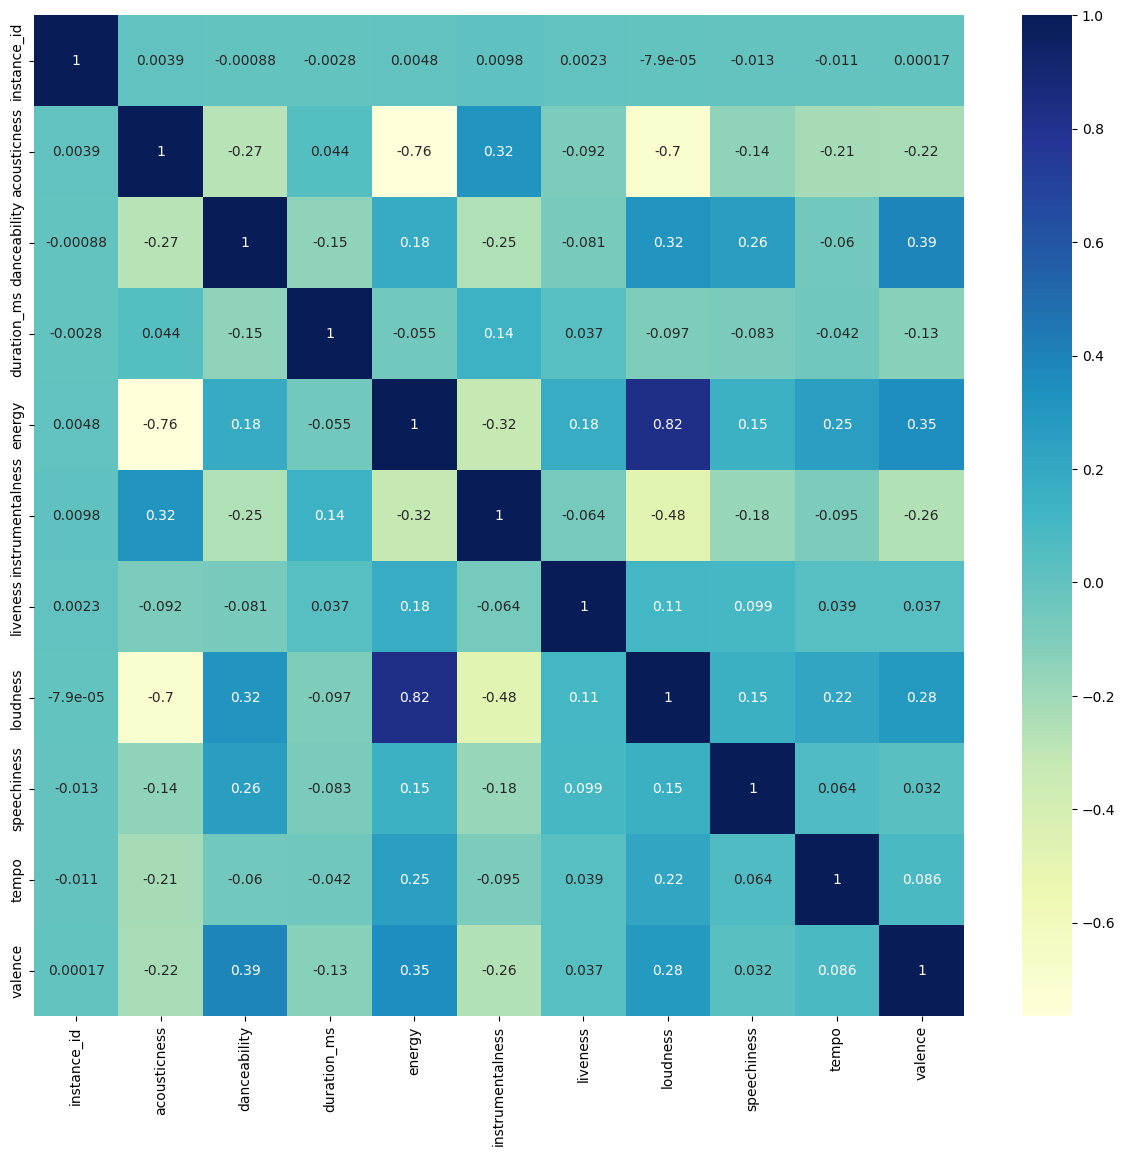

In [1526]:
info_df(train_data)

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
d

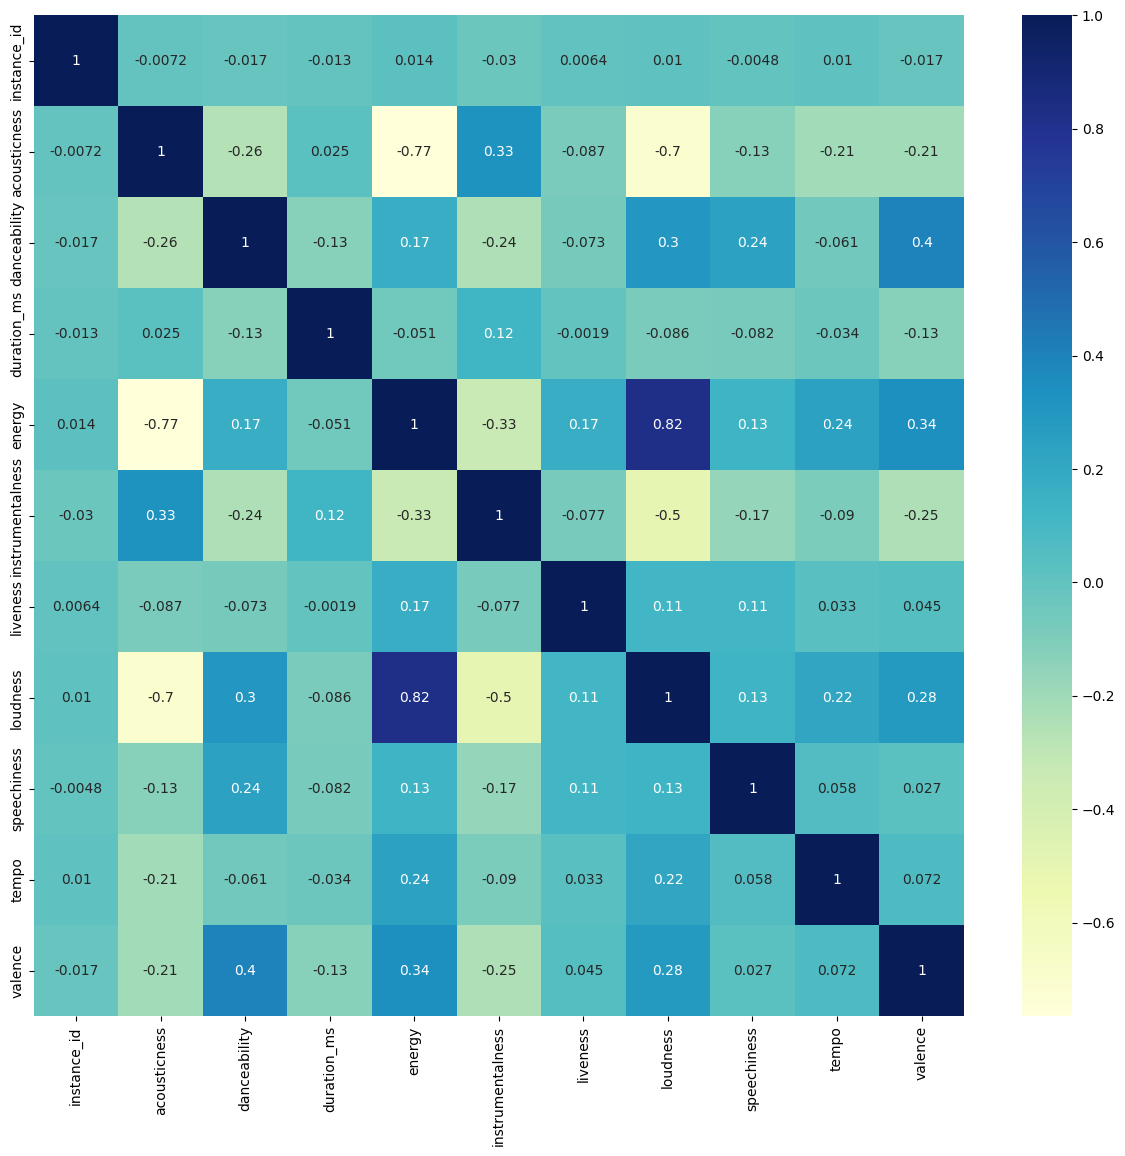

In [1527]:
info_df(test_data)

Посмотрим на соотношение пропусков данных

In [1528]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.600000
liveness,0.000000
loudness,0.000000


In [1529]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(test_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.100000
liveness,0.000000
loudness,0.000000


### Константы

In [1530]:
RANDOM_STATE = 1220

# Дополнительная информация из сторонних датасетов

In [1531]:
train_data_2 = pd.read_csv('/Users/sergeidolin/anaconda3/Projects/Music_genre_classification/Data/music_genre.csv')

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50005 entries, 0 to 50004
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       50000 non-null  float64
 1   artist_name       50000 non-null  object 
 2   track_name        50000 non-null  object 
 3   popularity        50000 non-null  float64
 4   acousticness      50000 non-null  float64
 5   danceability      50000 non-null  float64
 6   duration_ms       50000 non-null  float64
 7   energy            50000 non-null  float64
 8   instrumentalness  50000 non-null  float64
 9   key               50000 non-null  object 
 10  liveness          50000 non-null  float64
 11  loudness          50000 non-null  float64
 12  mode              50000 non-null  object 
 13  speechiness       50000 non-null  float64
 14  tempo             50000 non-null  object 

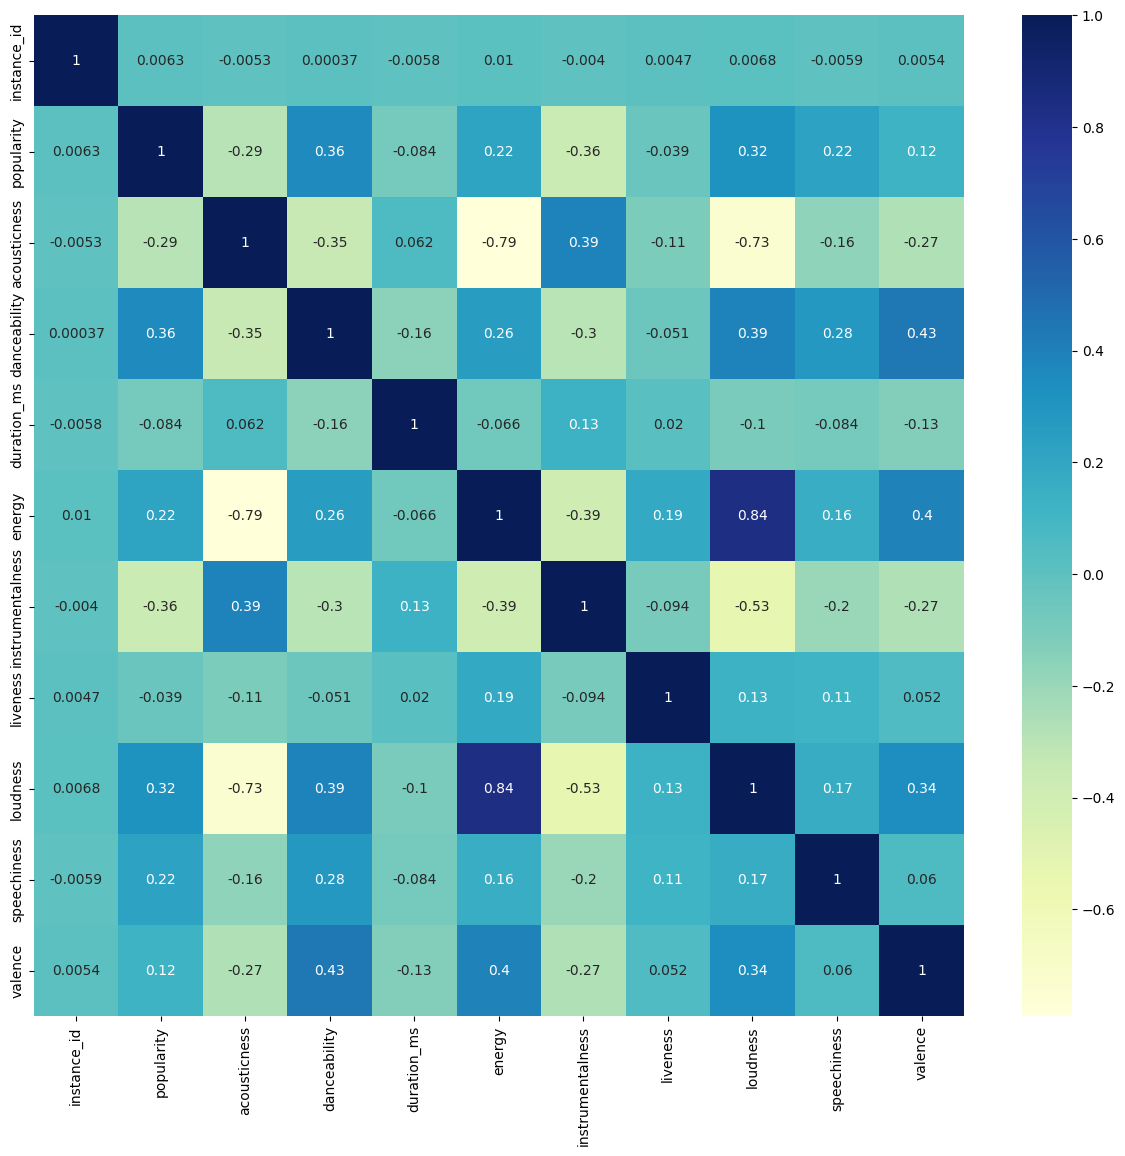

In [1532]:
info_df(train_data_2)

Перобразуем названия треков в новом датасете в название жанра для слияния двух таблиц

In [1533]:
train_data = train_data.drop(['instance_id', 'obtained_date', 'track_name'], axis=1)

In [1534]:
train_data_2 = train_data_2.drop(['artist_name', 'instance_id', 'obtained_date', 'popularity', 'track_name'], axis=1)

In [1535]:
train_data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,0.450,Country
1,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,0.539,Rock
2,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,0.344,Alternative
3,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,0.966,Hip-Hop
4,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,0.583,Alternative


In [1536]:
train_data_2.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


In [1537]:
train_data = pd.concat([train_data, train_data_2])

In [1538]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,1.100000
liveness,0.000000
loudness,0.000000
mode,0.700000
speechiness,0.000000


In [1539]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70399 entries, 0 to 50004
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70394 non-null  float64
 1   danceability      70394 non-null  float64
 2   duration_ms       70394 non-null  float64
 3   energy            70394 non-null  float64
 4   instrumentalness  70394 non-null  float64
 5   key               69659 non-null  object 
 6   liveness          70394 non-null  float64
 7   loudness          70394 non-null  float64
 8   mode              69888 non-null  object 
 9   speechiness       70394 non-null  float64
 10  tempo             69952 non-null  object 
 11  valence           70394 non-null  float64
 12  music_genre       70394 non-null  object 
dtypes: float64(9), object(4)
memory usage: 7.5+ MB
------------------------------
| Первые 1

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


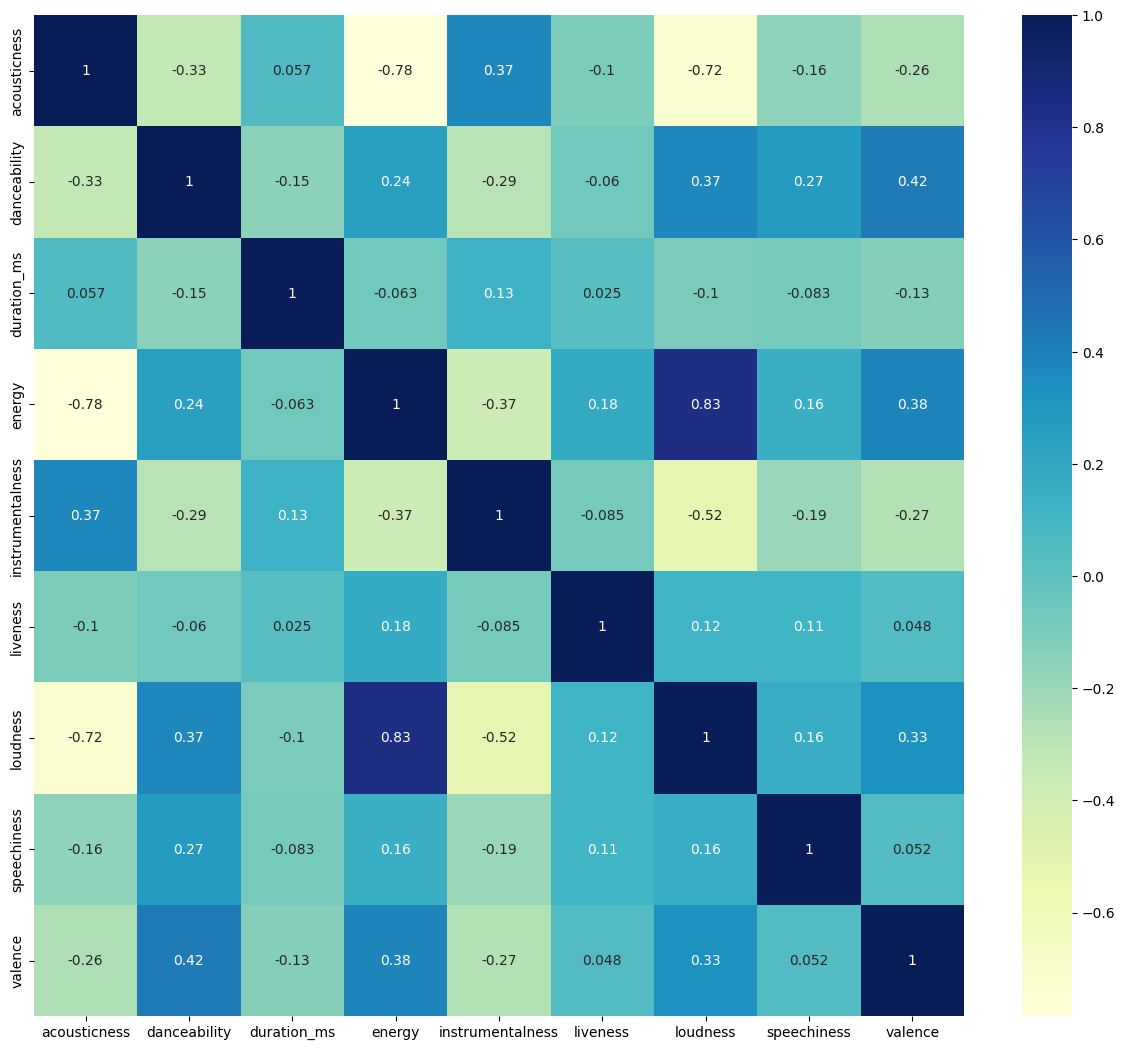

In [1540]:
info_df(train_data)

## Предобработка и исследовательский анализ данных

## Пропуски в данных

**Key**

In [1541]:
train_data.loc[train_data['key'].isna(), 'key'] = 'N'
train_data.loc[train_data['mode'].isna(), 'mode'] = 'N'

test_data.loc[test_data['key'].isna(), 'key'] = 'N'
test_data.loc[test_data['mode'].isna(), 'mode'] = 'N'

In [1542]:
mode_dict = {'Major' : 1, 'Minor' : 0, 'N': -1}
key_dict = {'N': -1,'C' : 1, 'C#' : 2, 'D' : 3, 'D#' : 4, 'E' : 5, 'F' : 6, 
        'F#' : 7, 'G' : 9, 'G#' : 10, 'A' : 11, 'A#' : 12, 'B' : 12}

train_data['mode'].replace(mode_dict, inplace=True)
train_data['key'] = train_data['key'].replace(key_dict).astype(int)
test_data['mode'].replace(mode_dict, inplace=True)
test_data['key'] = test_data['key'].replace(key_dict).astype(int)

In [1543]:
train_data['key'].unique()

array([ 3, 11,  5, 10,  1,  4, 12,  6,  7, -1,  9,  2])

**Tempo**

In [1544]:
train_data.loc[train_data['tempo'].isna() == True]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
63,0.287000,0.476,212427.0,0.612,0.000252,11,0.0877,-7.010,1,0.0335,NaN,0.909,Rock
85,0.000059,0.489,269000.0,0.947,0.000000,2,0.1130,-3.925,0,0.0419,NaN,0.517,Anime
114,0.348000,0.698,362267.0,0.800,0.000087,12,0.4430,-3.091,0,0.0284,NaN,0.654,Blues
138,0.008340,0.776,191210.0,0.783,0.044900,1,0.0377,-3.595,1,0.0374,NaN,0.943,Electronic
145,0.001100,0.608,178440.0,0.801,0.000008,11,0.2230,-5.452,0,0.0376,NaN,0.544,Alternative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,NaN,NaN,NaN


In [1545]:
test_data.loc[test_data['tempo'].isna() == True]

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
101,79753,She Walks In Beauty,0.981000,0.174,287360.0,0.0289,0.829000,9,0.0817,-25.038,1,0.0391,NaN,3-Apr,0.0315
131,27331,Tell Me Why,0.098400,0.611,142013.0,0.4490,0.000000,3,0.2260,-8.938,0,0.2940,NaN,4-Apr,0.2240
172,34855,Like You,0.383000,0.616,184033.0,0.4090,0.000000,2,0.1400,-8.427,1,0.2980,NaN,4-Apr,0.4530
212,43840,Matador (feat. Thompson Square),0.003600,0.528,241293.0,0.8250,0.000002,12,0.3690,-4.740,0,0.0602,NaN,4-Apr,0.4090
343,79286,New Fang,0.000010,0.276,228640.0,0.9620,0.000366,12,0.0327,-3.797,0,0.0629,NaN,4-Apr,0.7410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4918,50651,8 Bit Superhero,0.000346,0.377,296250.0,0.9200,0.903000,7,0.1950,-3.233,0,0.0529,NaN,4-Apr,0.1410
4923,89536,Whatcha Gonna Do With A Cowboy,0.342000,0.723,154000.0,0.8110,0.000000,11,0.0960,-4.147,1,0.1080,NaN,4-Apr,0.9210
4986,83279,First World Problemz / Nobody Carez,0.259000,0.582,350549.0,0.5020,0.000378,4,0.1600,-11.053,0,0.1020,NaN,4-Apr,0.5550
5076,54490,Deliver Me,0.000078,0.290,253839.0,0.8680,0.000005,2,0.4080,-4.392,1,0.0773,NaN,4-Apr,0.1930


In [1546]:
train_data[train_data['tempo'] == '?']

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,0.00523,0.755,519468.0,0.731,0.854000,3,0.2160,-10.517,0,0.0412,?,0.6140,Electronic
32,0.02330,0.729,274286.0,0.869,0.585000,6,0.0944,-7.569,0,0.1290,?,0.1380,Electronic
35,0.10800,0.493,-1.0,0.682,0.000000,11,0.1960,-5.781,0,0.2870,?,0.2390,Electronic
36,0.04780,0.646,253333.0,0.649,0.002520,9,0.3530,-5.259,1,0.1170,?,0.7270,Electronic
39,0.20300,0.769,429941.0,0.551,0.882000,12,0.1090,-12.520,0,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49918,0.29600,0.379,292520.0,0.644,0.000000,12,0.3130,-7.933,0,0.1120,?,0.1440,Hip-Hop
49964,0.08470,0.929,215200.0,0.737,0.000000,10,0.8610,-6.424,1,0.1020,?,0.8860,Hip-Hop
49967,0.17900,0.860,233293.0,0.625,0.000136,3,0.3000,-6.922,1,0.1050,?,0.2210,Hip-Hop
49976,0.70000,0.462,225067.0,0.741,0.000000,12,0.3400,-8.008,0,0.1620,?,0.5890,Hip-Hop


In [1547]:
test_data[test_data['tempo'] == '?']

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence


In [1548]:
for genre in train_data['music_genre'].unique():
    train_data.loc[(train_data['music_genre'] == genre) 
                   & (train_data['tempo'] == '?') 
                   | (train_data['tempo'].isna() == True),
                   'tempo'] = \
    train_data.loc[(train_data['music_genre'] == genre)
                   & (train_data['tempo'] != '?'),
                     'tempo'].median()

In [1549]:
test_data.loc[test_data['tempo'].isna() == True,'tempo'] = 0

In [1550]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.000000
liveness,0.000000
loudness,0.000000
mode,0.000000
speechiness,0.000000


Проверим наличие явных дубликатов

In [1551]:
train_data.duplicated().sum()

44

In [1552]:
train_data = train_data.drop_duplicates().reset_index(drop=True)

In [1553]:
train_data[train_data['music_genre'].isna()]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
30375,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,-1,NaN,122.862,NaN,NaN


## Преобразование типов данных

In [1554]:
train_data['tempo'] = train_data['tempo'].astype('float32')

#### Поиск аномальных значений

Взглянем еще раз на данные нашего тренировачного датасета

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70355 entries, 0 to 70354
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      70354 non-null  float64
 1   danceability      70354 non-null  float64
 2   duration_ms       70354 non-null  float64
 3   energy            70354 non-null  float64
 4   instrumentalness  70354 non-null  float64
 5   key               70355 non-null  int64  
 6   liveness          70354 non-null  float64
 7   loudness          70354 non-null  float64
 8   mode              70355 non-null  int64  
 9   speechiness       70354 non-null  float64
 10  tempo             70355 non-null  float32
 11  valence           70354 non-null  float64
 12  music_genre       70354 non-null  object 
dtypes: float32(1), float64(9), int64(2), object(1)
memory usage: 6.7+ MB
-------------------

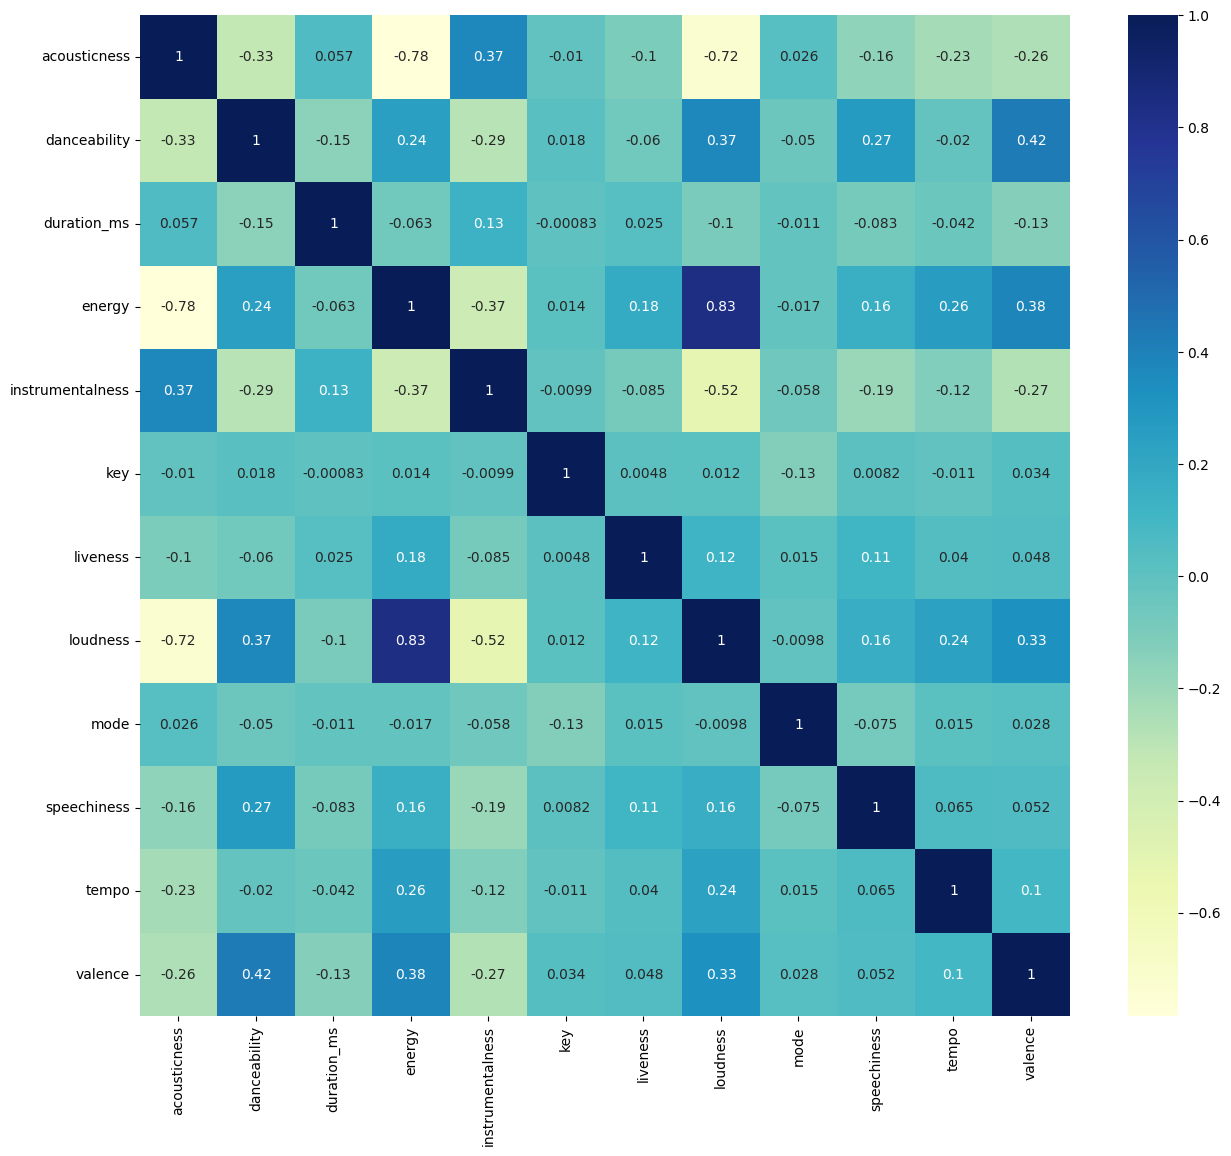

In [1555]:
info_df(train_data)

In [1556]:
train_data.duplicated().sum()

18748

In [1557]:
train_data = train_data.drop_duplicates().reset_index(drop=True)

Обратим внимание на длительность некоторых треков в -1 миллисекунду. Вариантов несколько: можно удалить все треки которые имеют такое значение и потерять кусочек данных, можно заменить медианным значением всех треков, а можно оставить как есть и перед обучением модели (после масштабирования признаков) занизить это значение, дабы оно не влияло на обучение

**Длительность трека**

Оценим экстремумы треков в датасете

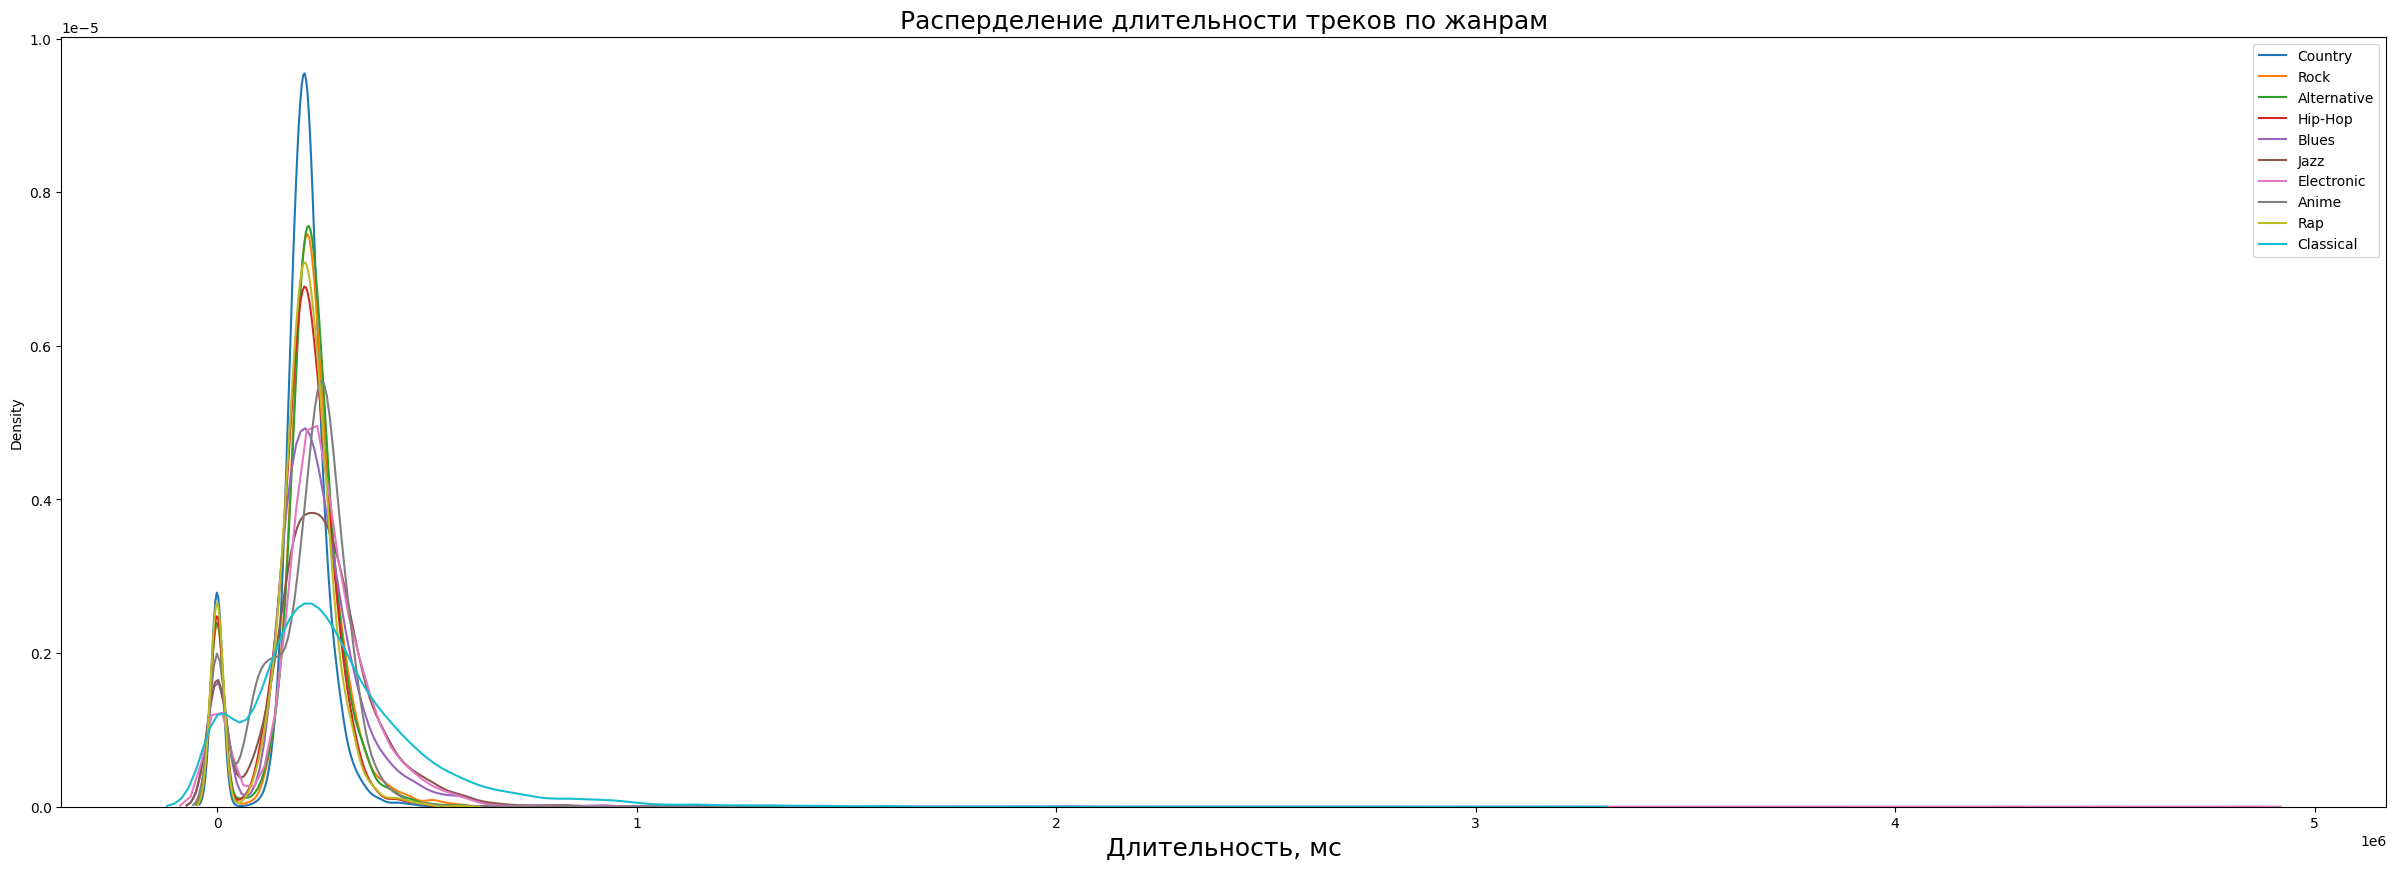

In [1558]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[train_data['music_genre']==genre, 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Видно, что данные имеют аномальные значения. Особенно это видно на максимальной длительности трека. Возьмем ограничения в 2 стандартных отклонения

In [1559]:
print((train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95]
               .groupby('music_genre')['tempo']
               .agg({'count'})))

print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                < train_data['duration_ms']
               .std() * 0.95, 'tempo']
               .count()))

             count
music_genre       
Alternative    592
Anime         1033
Blues          581
Classical      998
Country        523
Electronic     579
Hip-Hop        676
Jazz           744
Rap            691
Rock           568
Всего треков: 6985


Наибольшее количество коротких треков относится к жанрам:
- `Anime`
- `Classical`
- `Jazz`


In [1560]:
print((train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2]
               .groupby('music_genre')['tempo']
               .agg('count')))
print('Всего треков:', (train_data.loc[train_data['duration_ms'] 
                > train_data['duration_ms']
               .std() * 2, 'tempo']
               .count()))

music_genre
Alternative    1254
Anime          1774
Blues          1751
Classical      2351
Country         677
Electronic     2047
Hip-Hop        1065
Jazz           2098
Rap             974
Rock           1302
Name: tempo, dtype: int64
Всего треков: 15293


А наибольшее количество долгих треков относится к жанрам:
- `Classical`
- `Jazz`
- `Electronic`



Отберем только те треки длительность которых укладывается в заданый нами интервал и оценим расспределение длительности треков по жанрам

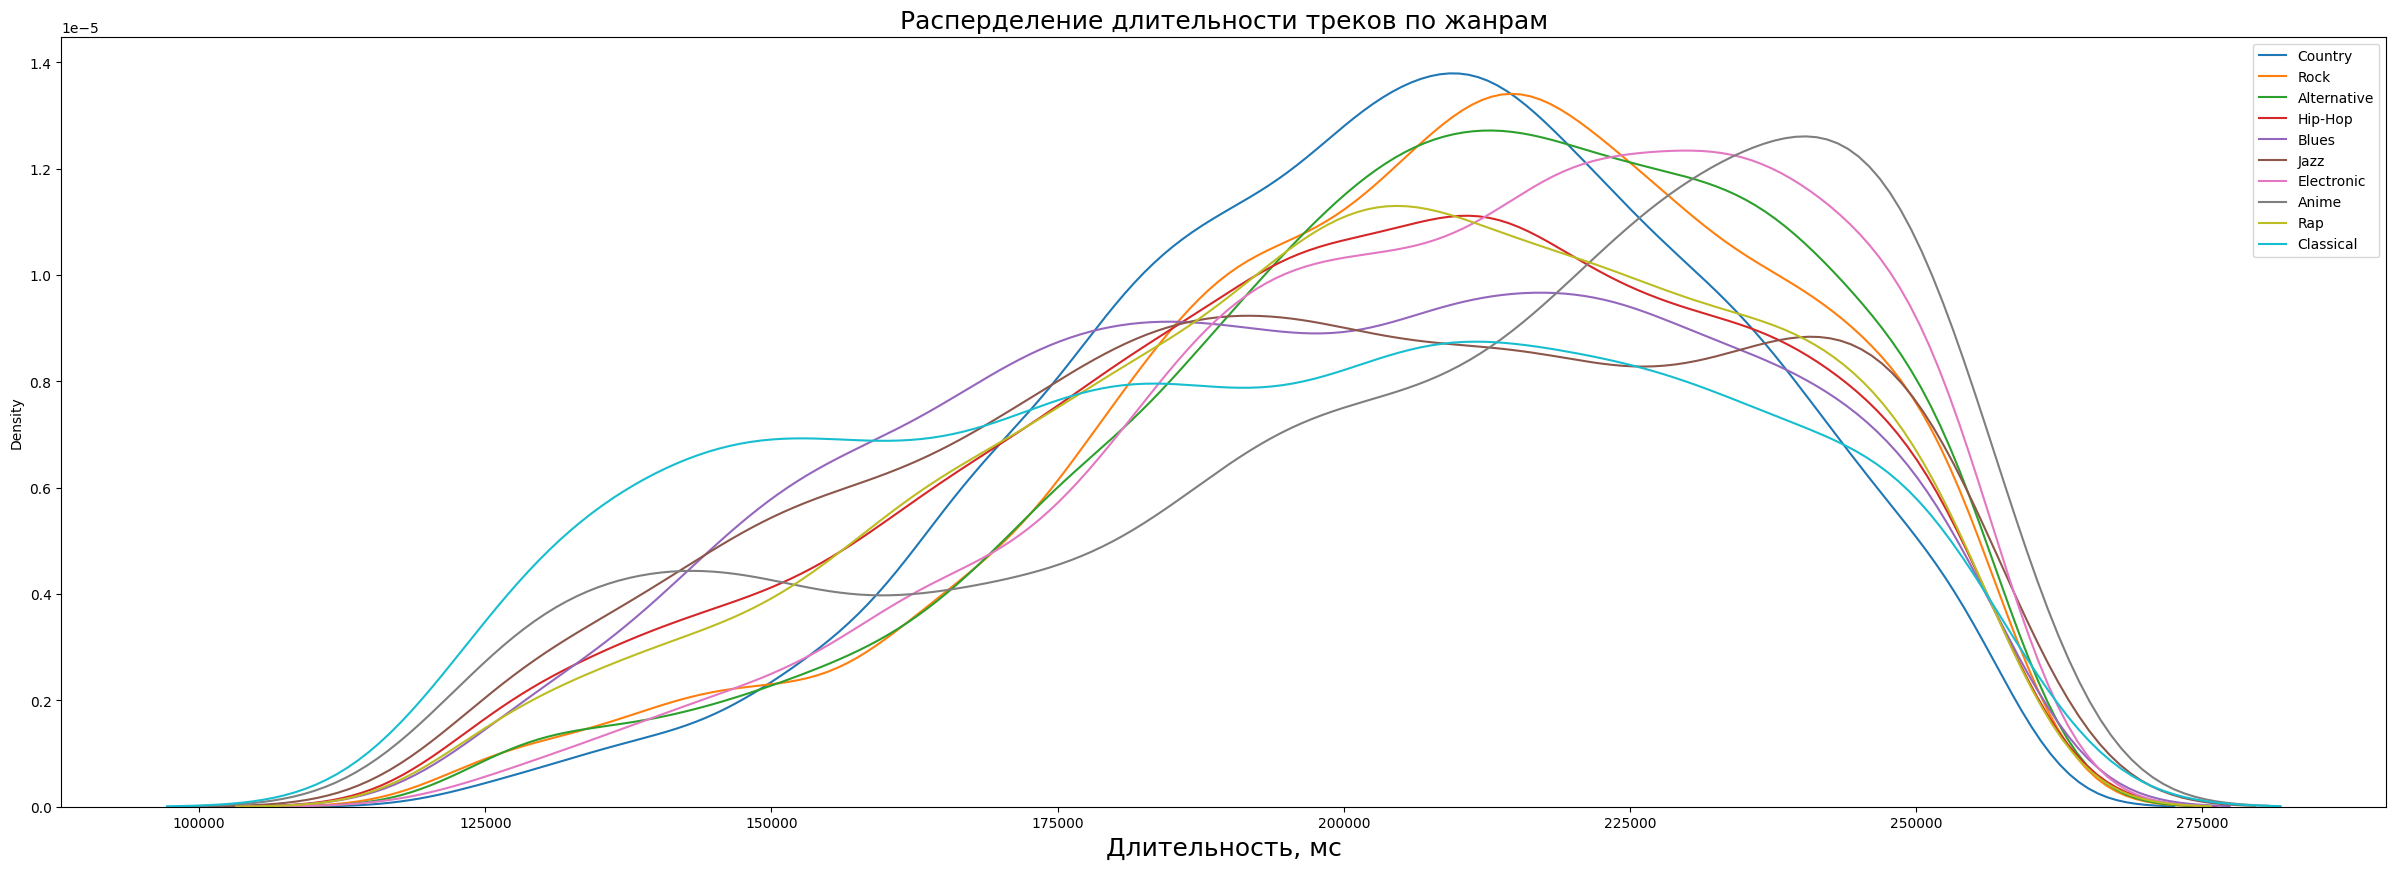

In [1561]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre) & 
                                   ((train_data['duration_ms'] > train_data['duration_ms'].std() * 0.95) & 
                                    (train_data['duration_ms'] < train_data['duration_ms'].std() * 2)), 'duration_ms'], label=genre)

plt.title("Расперделение длительности треков по жанрам", fontsize = 18)

plt.xlabel("Длительность, мс", fontsize = 18)
plt.legend();

Создадим новый признак `duration_class` который будет являтся идентификатором длительности трека (до OHE: short: -1, median: 0, long: 1)

In [1562]:
def sml_train_songs(row):
    if row < train_data['duration_ms'].std() * 0.95:
        return -1
    elif row > train_data['duration_ms'].std() * 3:
        return 1
    else:
        return 0

In [1563]:
def sml_test_songs(row):
    if row < test_data['duration_ms'].std() * 0.95:
        return -1
    elif row > test_data['duration_ms'].std() * 3:
        return 1
    else:
        return 0

In [1564]:
train_data['duration_class'] = train_data['duration_ms'].apply(sml_train_songs)

In [1565]:
test_data['duration_class'] = test_data['duration_ms'].apply(sml_test_songs)

**Привлекательность**

Рассмотрим корреляцию между параметрами `liveness` - привлекательность и `valence` - привлекательность произведения для пользователей сервиса.


/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/2409429548.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(df.corr(), cmap="YlGnBu", annot=True)


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51607 entries, 0 to 51606
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      51606 non-null  float64
 1   danceability      51606 non-null  float64
 2   duration_ms       51606 non-null  float64
 3   energy            51606 non-null  float64
 4   instrumentalness  51606 non-null  float64
 5   key               51607 non-null  int64  
 6   liveness          51606 non-null  float64
 7   loudness          51606 non-null  float64
 8   mode              51607 non-null  int64  
 9   speechiness       51606 non-null  float64
 10  tempo             51607 non-null  float32
 11  valence           51606 non-null  float64
 12  music_genre       51606 non-null  object 
 13  duration_class    51607 non-null  int64  
dtypes: float32(1), float64(9), int64(3), obje

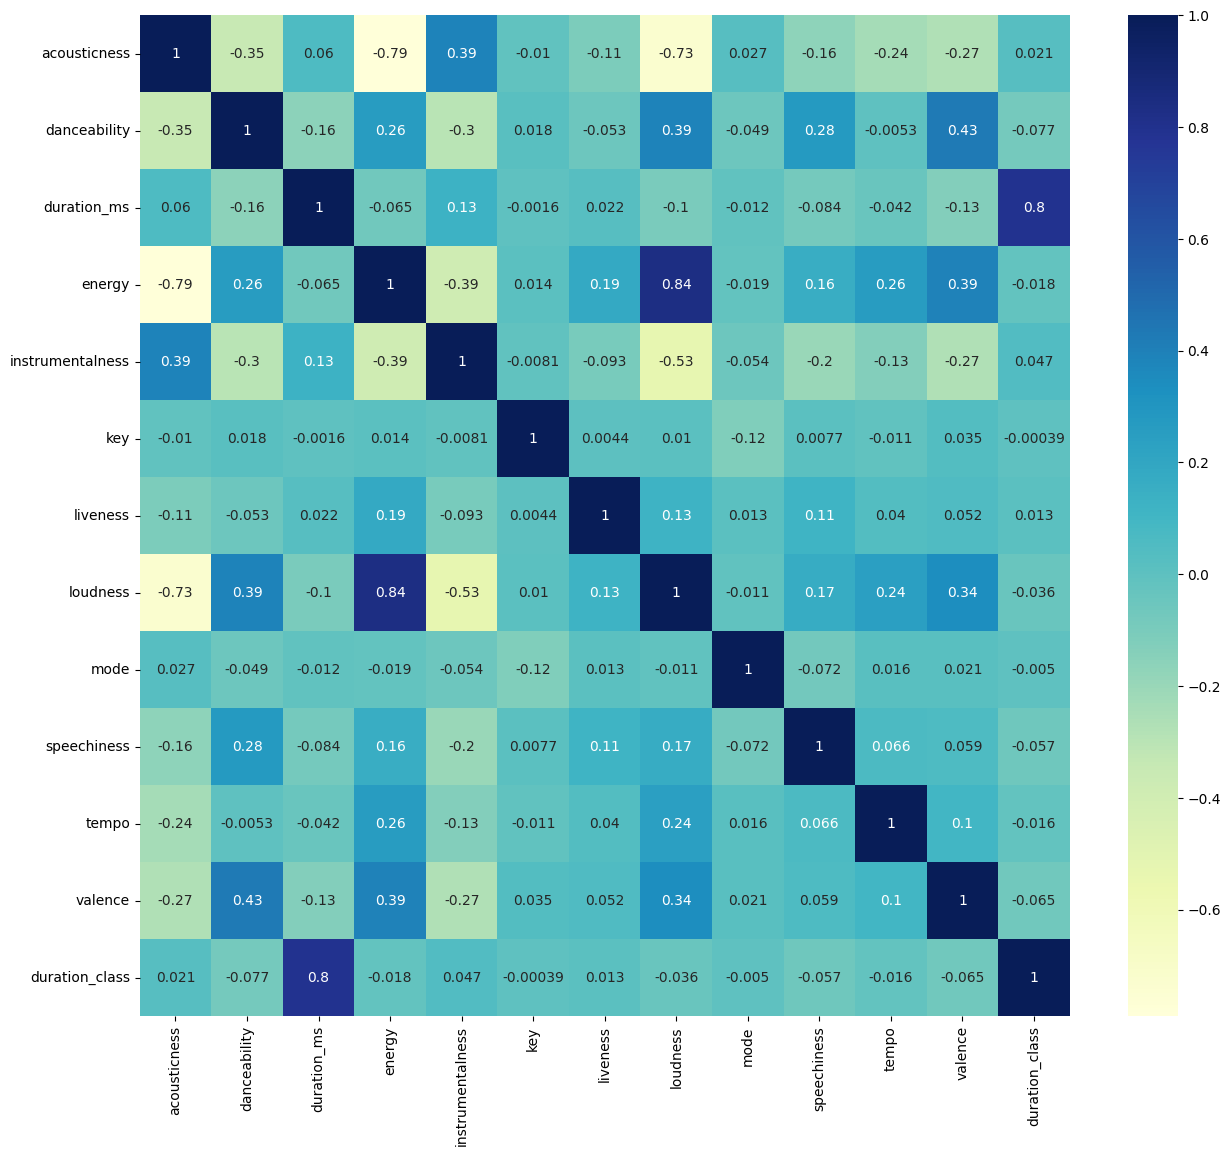

In [1566]:
info_df(train_data)

Линейной зависимости от этих двух параметров не наблюдается. Оставим оба этих параметра и выберем наилучший путем рассчета значения Шэпли.

**Темп**

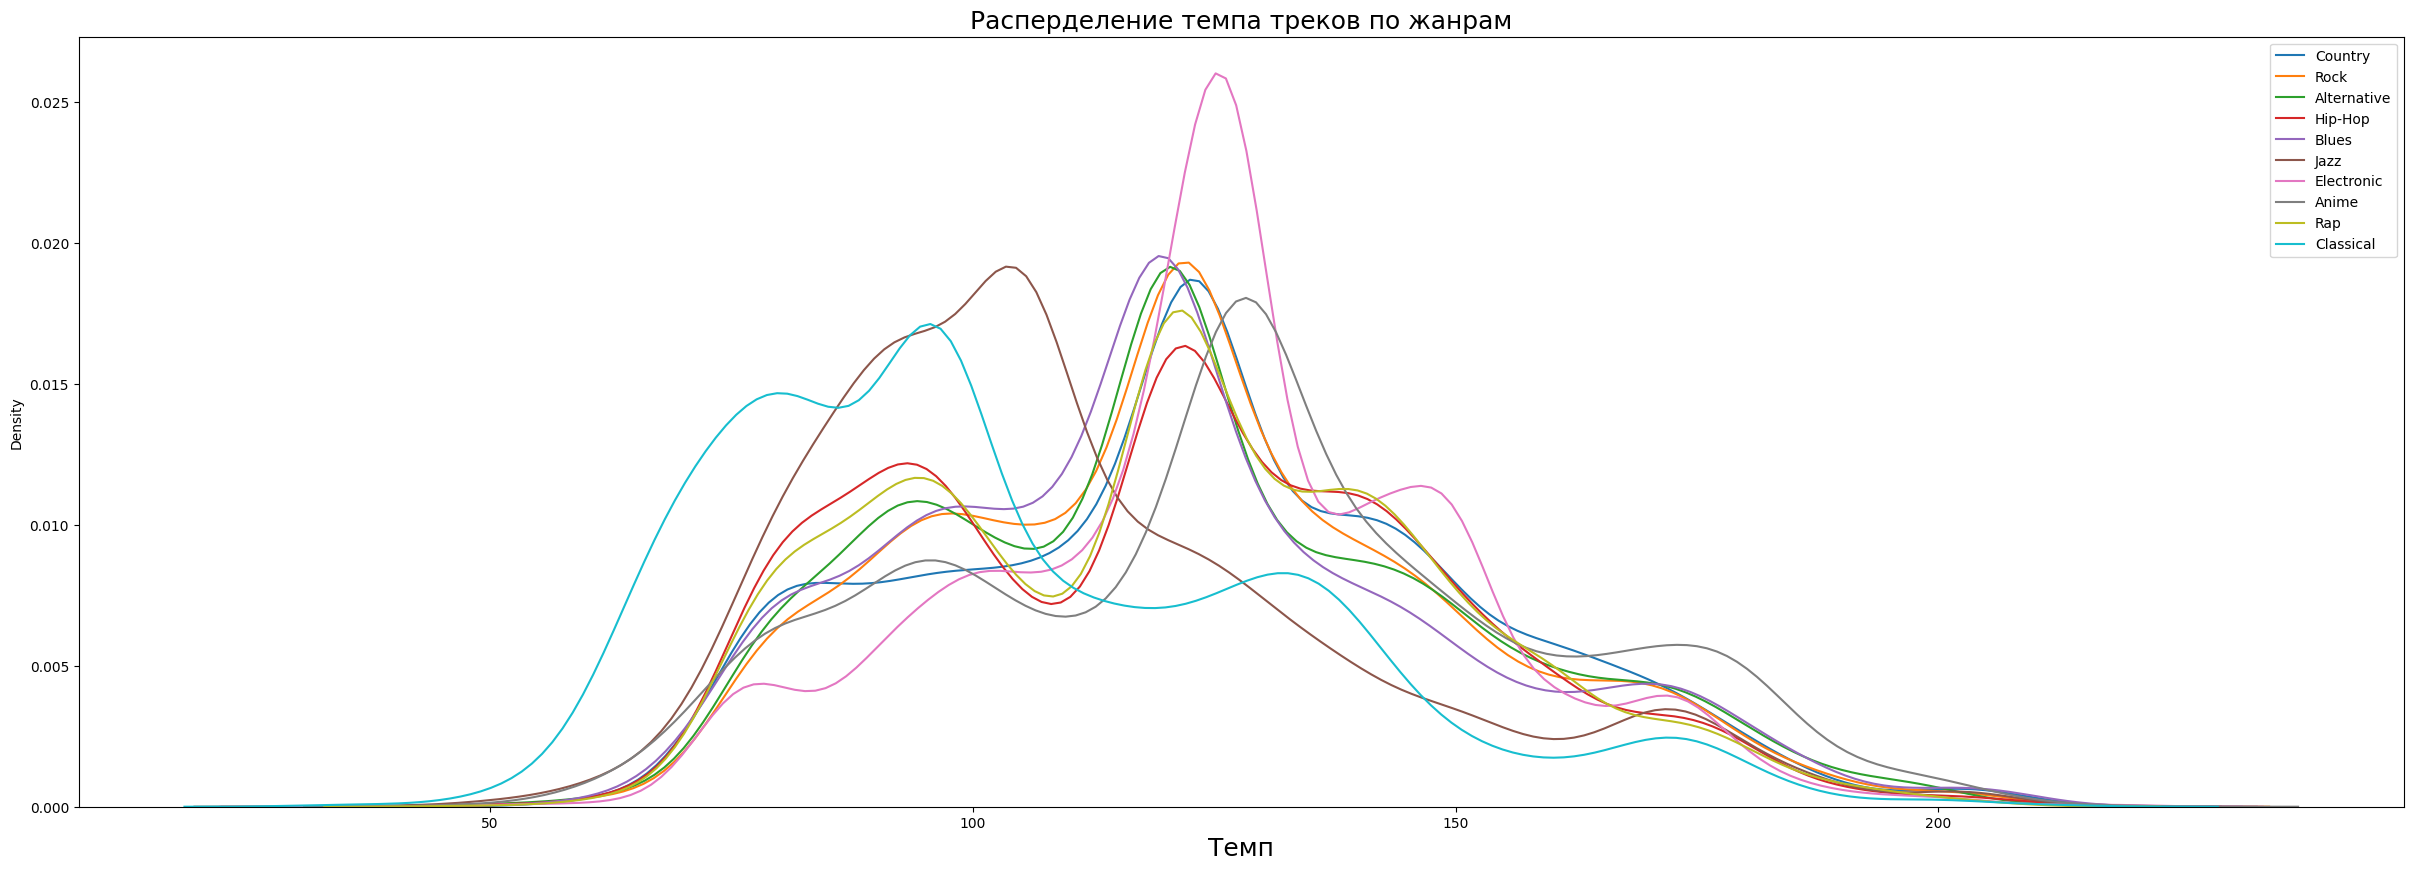

In [1567]:
plt.figure(figsize=(30,10))
for genre in train_data['music_genre'].unique():
    sb.kdeplot(data=train_data.loc[(train_data['music_genre']==genre), 'tempo'], label=genre)

plt.title("Расперделение темпа треков по жанрам", fontsize = 18)

plt.xlabel("Темп", fontsize = 18)
plt.legend();

Можно отметить что для жанров Классической музыки, Джаза и Электронной  характерен высокий темп исполнения. Для заполнения пропусков в параметре Темп разделим медианное значение жанров Классика, Джаз, Электронная и оставшиеся жанры.

# Подготовка признаков

Исследуем модели `LogisticRegression` и `CatBoost`. 

Рассмотрим долю жанров в датасете

In [1568]:
train_data['music_genre'].value_counts()/len(train_data)

Blues          0.101285
Rap            0.101052
Alternative    0.100820
Rock           0.100548
Electronic     0.100548
Country        0.100200
Anime          0.099773
Classical      0.098843
Hip-Hop        0.098494
Jazz           0.098417
Name: music_genre, dtype: float64

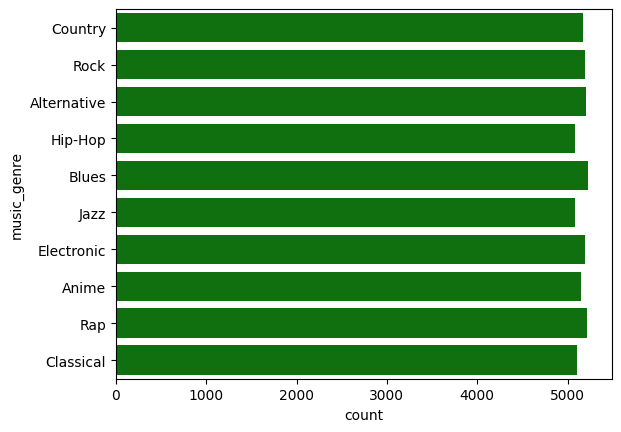

In [1569]:
sb.countplot(y="music_genre", data=train_data, color='green');

In [1570]:
train_data.isna().sum()

acousticness        1
danceability        1
duration_ms         1
energy              1
instrumentalness    1
key                 0
liveness            1
loudness            1
mode                0
speechiness         1
tempo               0
valence             1
music_genre         1
duration_class      0
dtype: int64

In [1571]:
train_data = train_data.dropna()

In [1572]:
print('---------------------------------')
print('| Proportion of missing values. |')
print('---------------------------------')
pd.DataFrame(round(train_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

---------------------------------
| Proportion of missing values. |
---------------------------------


,0
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.000000
liveness,0.000000
loudness,0.000000
mode,0.000000
speechiness,0.000000


## Исследование мультиколлениарности

In [1573]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [1574]:
train_data = train_data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [1575]:
features = train_data.drop(['music_genre'], axis = 1)
target = train_data['music_genre']

features_test = test_data
target_test = submit_test['music_genre']

Мультиколлениарность - это наличие линейной зависимости между регрессорами. Посмотрим на ковариационную матрицу наших признаков.

------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51606 entries, 0 to 51605
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      51606 non-null  float64
 1   danceability      51606 non-null  float64
 2   duration_ms       51606 non-null  float64
 3   energy            51606 non-null  float64
 4   instrumentalness  51606 non-null  float64
 5   key               51606 non-null  int64  
 6   liveness          51606 non-null  float64
 7   loudness          51606 non-null  float64
 8   mode              51606 non-null  int64  
 9   speechiness       51606 non-null  float64
 10  tempo             51606 non-null  float32
 11  valence           51606 non-null  float64
 12  duration_class    51606 non-null  int64  
dtypes: float32(1), float64(9), int64(3)
memory usage: 4.9 MB
------------------------------


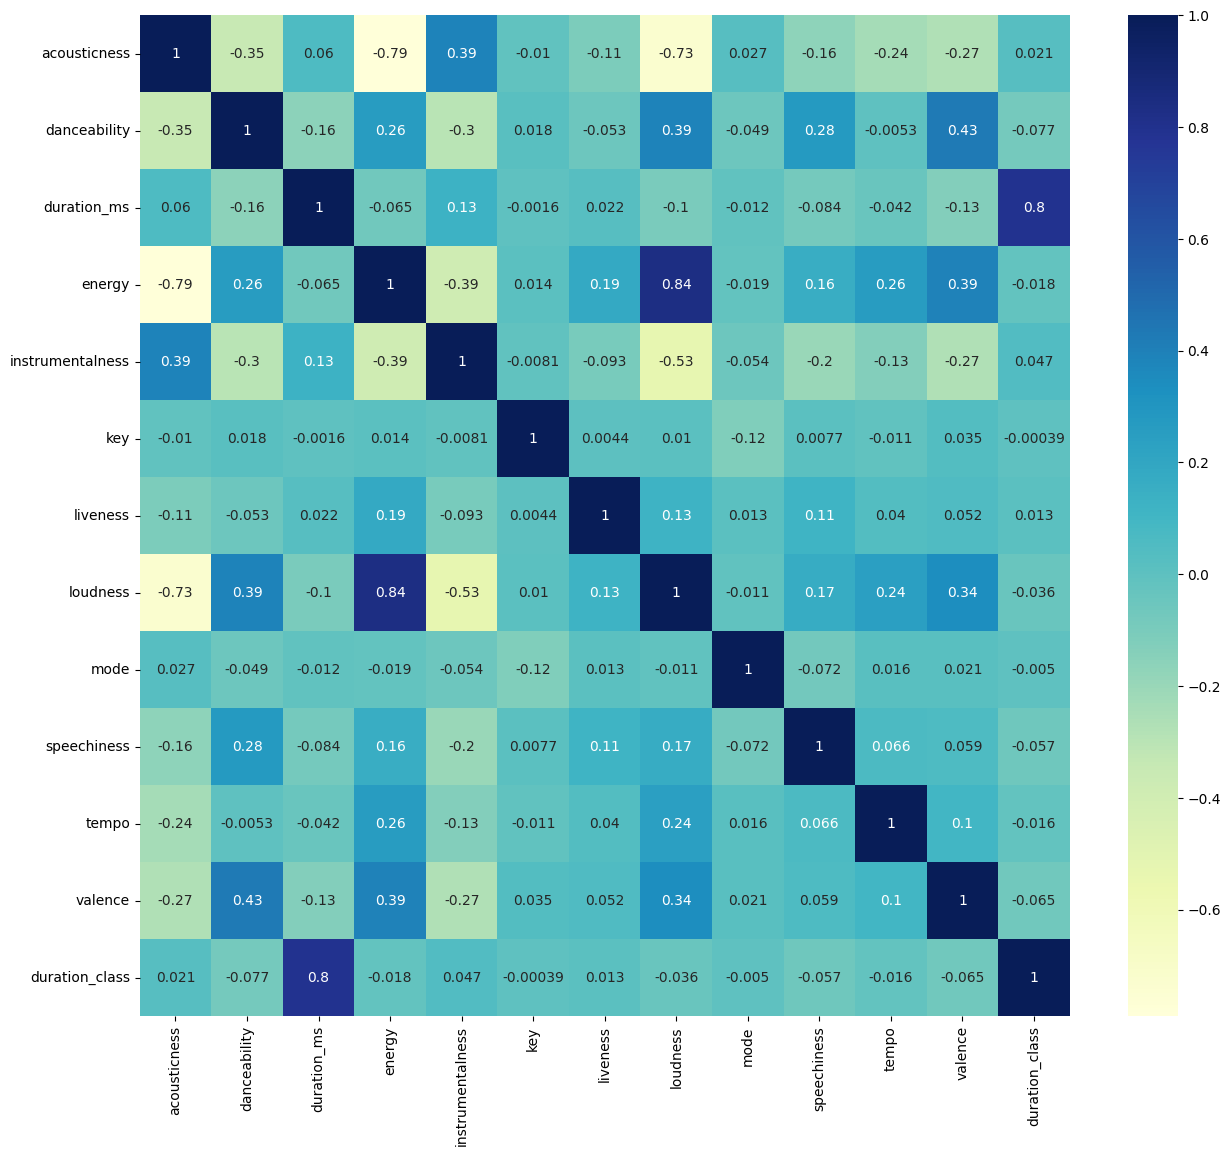

In [1576]:
info_df(features)

Обратим внимание что некоторые признаки имеют высокую степень кореляции Пирсона. Пирсон — отличный выбор, когда у есть непрерывные данные для пары переменных, а взаимосвязи следуют прямой линии. Но, пришло время найти другую меру корреляции!

Корреляция Спирмена в статистике является непараметрической альтернативой корреляциям Пирсона. Используйте корреляцию Спирмена для данных, которые следуют криволинейным, монотонным отношениям, а также для порядковых данных.

А также вычислим коэффициент вздутия дисперсии (VIF)

<Axes: >

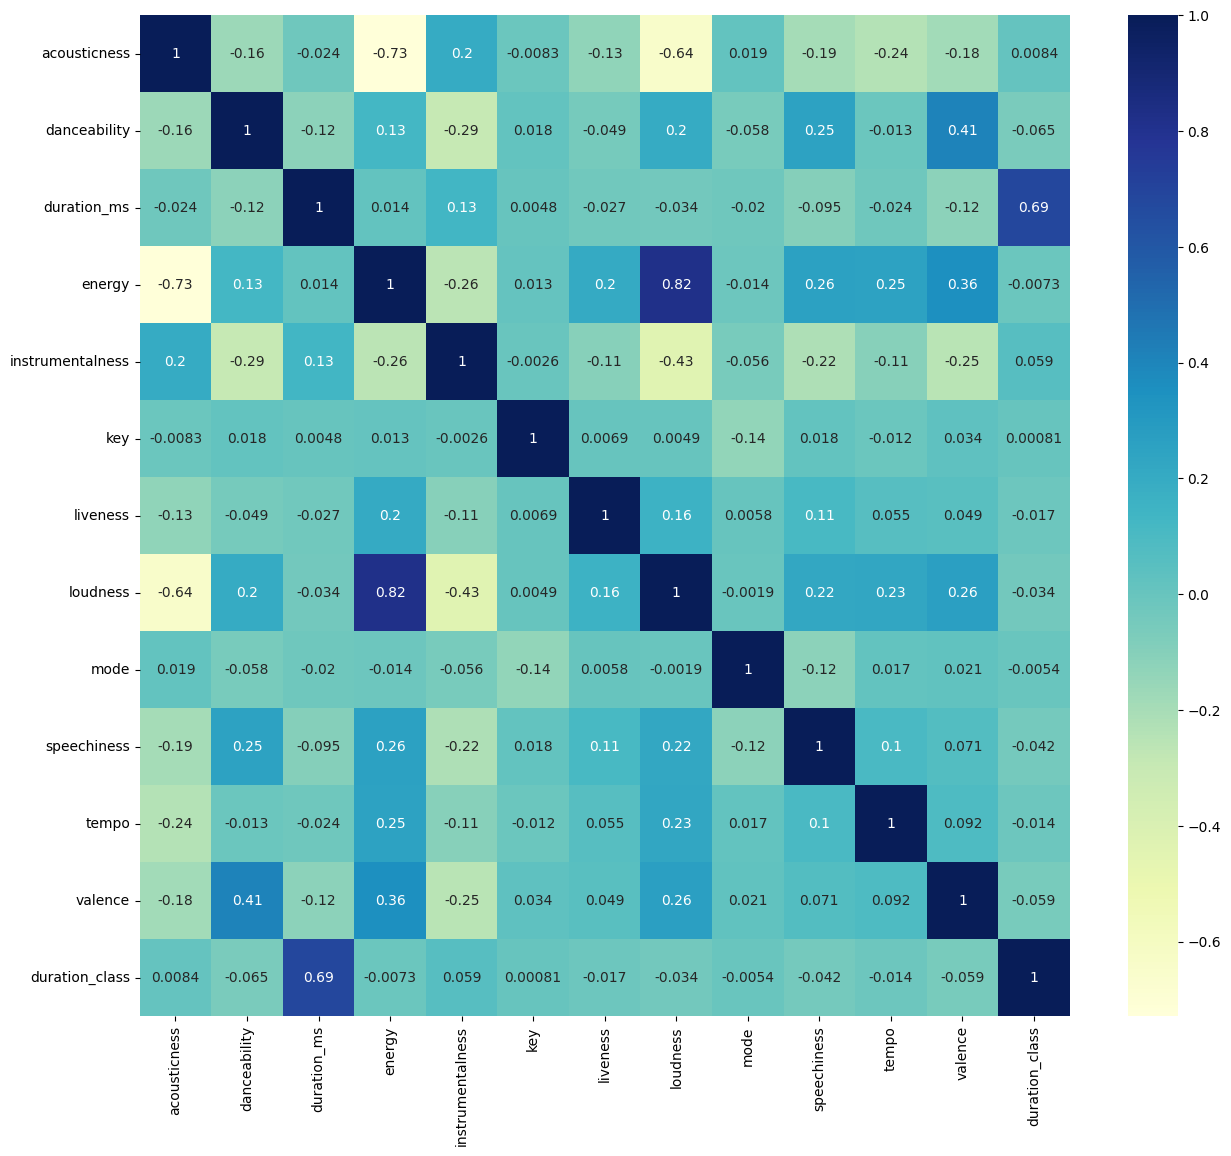

In [1577]:
plt.figure(figsize=(15, 13))
sb.heatmap(features.corr(method='spearman'), cmap="YlGnBu", annot=True)


In [1578]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.values, i)
                          for i in range(len(features.columns))]
  
print(vif_data)

             feature        VIF
0       acousticness   4.451306
1       danceability  12.066768
2        duration_ms  10.251057
3             energy  17.119269
4   instrumentalness   1.943107
5                key   3.646766
6           liveness   2.595463
7           loudness   9.047712
8               mode   2.565573
9        speechiness   2.128305
10             tempo  16.088922
11           valence   6.426808
12    duration_class   2.688659


In [1579]:
vif_data = pd.DataFrame()
vif_data["feature"] = features.drop(['tempo','energy','danceability'], axis=1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features.drop(['tempo','energy','danceability'], axis=1).values, i)
                          for i in range(len(features.drop(['tempo','energy','danceability'], axis=1).columns))]
  
print(vif_data)

            feature       VIF
0      acousticness  3.882691
1       duration_ms  7.061848
2  instrumentalness  1.902572
3               key  3.330260
4          liveness  2.395542
5          loudness  7.623468
6              mode  2.407174
7       speechiness  1.864753
8           valence  3.791033
9    duration_class  2.161940


In [1580]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).values, i)
                          for i in range(len(features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1).columns))]
  
print(vif_data)

             feature        VIF
0       acousticness   3.885038
1       danceability  12.387140
2        duration_ms  14.313863
3             energy  17.024287
4   instrumentalness   1.814789
5                key   3.485479
6           liveness   2.559045
7           loudness   8.770401
8               mode   2.210310
9        speechiness   2.099038
10             tempo  11.664575
11           valence   6.494553
12    duration_class   3.278707


Существует общее правило что если VIF больше 10, то это флаг о том что эти регрессоры проявляют мультиколлениарность

In [1581]:
# features = features.drop(['tempo','energy','danceability'], axis=1)
# features_test = features_test.drop(['instance_id', 'track_name','obtained_date','tempo','energy','danceability'], axis=1)

In [1582]:
features_test = features_test.drop(['instance_id', 'track_name','obtained_date'], axis=1)

In [1583]:
oversample = SMOTE(random_state=RANDOM_STATE, k_neighbors=10)
features_up, target_up = oversample.fit_resample(features, target)

In [1584]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features_up, target_up, train_size=0.75, random_state=RANDOM_STATE, stratify=target_up)

In [1585]:
features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, train_size=0.75, random_state=RANDOM_STATE, stratify=target)

In [1586]:
print(f"Train set has {features_train.shape[0]} records out of {len(train_data)} which is {round(features_train.shape[0]/len(train_data)*100)}%")
print(f"Valid set has {features_valid.shape[0]} records out of {len(train_data)} which is {round(features_valid.shape[0]/len(train_data)*100)}%")
print(f"Test set has {features_test.shape[0]} records out of {len(test_data)} which is {round(features_test.shape[0]/len(test_data)*100)}%")

Train set has 38704 records out of 51606 which is 75%
Valid set has 12902 records out of 51606 which is 25%
Test set has 5099 records out of 5099 which is 100%


In [1587]:
target_train.value_counts().sort_index()

Alternative    3902
Anime          3862
Blues          3920
Classical      3826
Country        3878
Electronic     3892
Hip-Hop        3812
Jazz           3809
Rap            3911
Rock           3892
Name: music_genre, dtype: int64

In [1588]:
%%time
model = LogisticRegression(multi_class = 'multinomial', solver='lbfgs', max_iter=200, class_weight='balanced')

CPU times: user 15 µs, sys: 59 µs, total: 74 µs
Wall time: 76.1 µs


In [1589]:
model.fit(features_train, target_train)

LogisticRegression(class_weight='balanced', max_iter=200,
                   multi_class='multinomial')

In [1590]:
y_pred = model.predict(features_valid)

In [1591]:
from sklearn.metrics import classification_report
print(classification_report(target_valid, y_pred))

              precision    recall  f1-score   support

 Alternative       0.00      0.00      0.00      1301
       Anime       0.10      0.27      0.14      1287
       Blues       0.00      0.00      0.00      1307
   Classical       0.23      0.46      0.30      1275
     Country       0.09      0.14      0.11      1293
  Electronic       0.11      0.39      0.17      1297
     Hip-Hop       0.00      0.00      0.00      1271
        Jazz       0.00      0.00      0.00      1270
         Rap       0.00      0.00      0.00      1304
        Rock       0.00      0.00      0.00      1297

    accuracy                           0.13     12902
   macro avg       0.05      0.13      0.07     12902
weighted avg       0.05      0.13      0.07     12902



/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sergeidolin/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [1592]:
rfc = RandomForestClassifier(n_estimators=100,max_depth=35,min_samples_leaf = 2, random_state=RANDOM_STATE, class_weight='balanced')
rfc.fit(features_train, target_train)

RandomForestClassifier(class_weight='balanced', max_depth=35,
                       min_samples_leaf=2, random_state=1220)

In [1593]:
y_rfc = rfc.predict(features_valid)

In [1594]:
print(classification_report(target_valid, y_rfc))

              precision    recall  f1-score   support

 Alternative       0.31      0.26      0.28      1301
       Anime       0.58      0.53      0.56      1287
       Blues       0.43      0.46      0.45      1307
   Classical       0.80      0.85      0.83      1275
     Country       0.49      0.59      0.54      1293
  Electronic       0.59      0.64      0.61      1297
     Hip-Hop       0.34      0.42      0.38      1271
        Jazz       0.48      0.50      0.49      1270
         Rap       0.32      0.29      0.30      1304
        Rock       0.26      0.17      0.21      1297

    accuracy                           0.47     12902
   macro avg       0.46      0.47      0.46     12902
weighted avg       0.46      0.47      0.46     12902



In [1595]:
from sklearn.feature_selection import RFE
selector = RFE(rfc, n_features_to_select=1)
selector.fit(features_train, target_train)

RFE(estimator=RandomForestClassifier(class_weight='balanced', max_depth=35,
                                     min_samples_leaf=2, random_state=1220),
    n_features_to_select=1)

In [1596]:
print(f"Model's Feature Importance")
for i in range(len(selector.ranking_)):
    print(f"#{i+1}: {features_train.columns[selector.ranking_[i]-1]} ")

Model's Feature Importance
#1: duration_ms 
#2: instrumentalness 
#3: mode 
#4: liveness 
#5: key 
#6: tempo 
#7: speechiness 
#8: danceability 
#9: valence 
#10: energy 
#11: acousticness 
#12: loudness 
#13: duration_class 


------------------------------
| Информация о наборе данных |
------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38704 entries, 17330 to 28368
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      38704 non-null  float64
 1   danceability      38704 non-null  float64
 2   duration_ms       38704 non-null  float64
 3   energy            38704 non-null  float64
 4   instrumentalness  38704 non-null  float64
 5   key               38704 non-null  int64  
 6   liveness          38704 non-null  float64
 7   loudness          38704 non-null  float64
 8   mode              38704 non-null  int64  
 9   speechiness       38704 non-null  float64
 10  tempo             38704 non-null  float32
 11  valence           38704 non-null  float64
 12  duration_class    38704 non-null  int64  
dtypes: float32(1), float64(9), int64(3)
memory usage: 4.0 MB
---------------------------

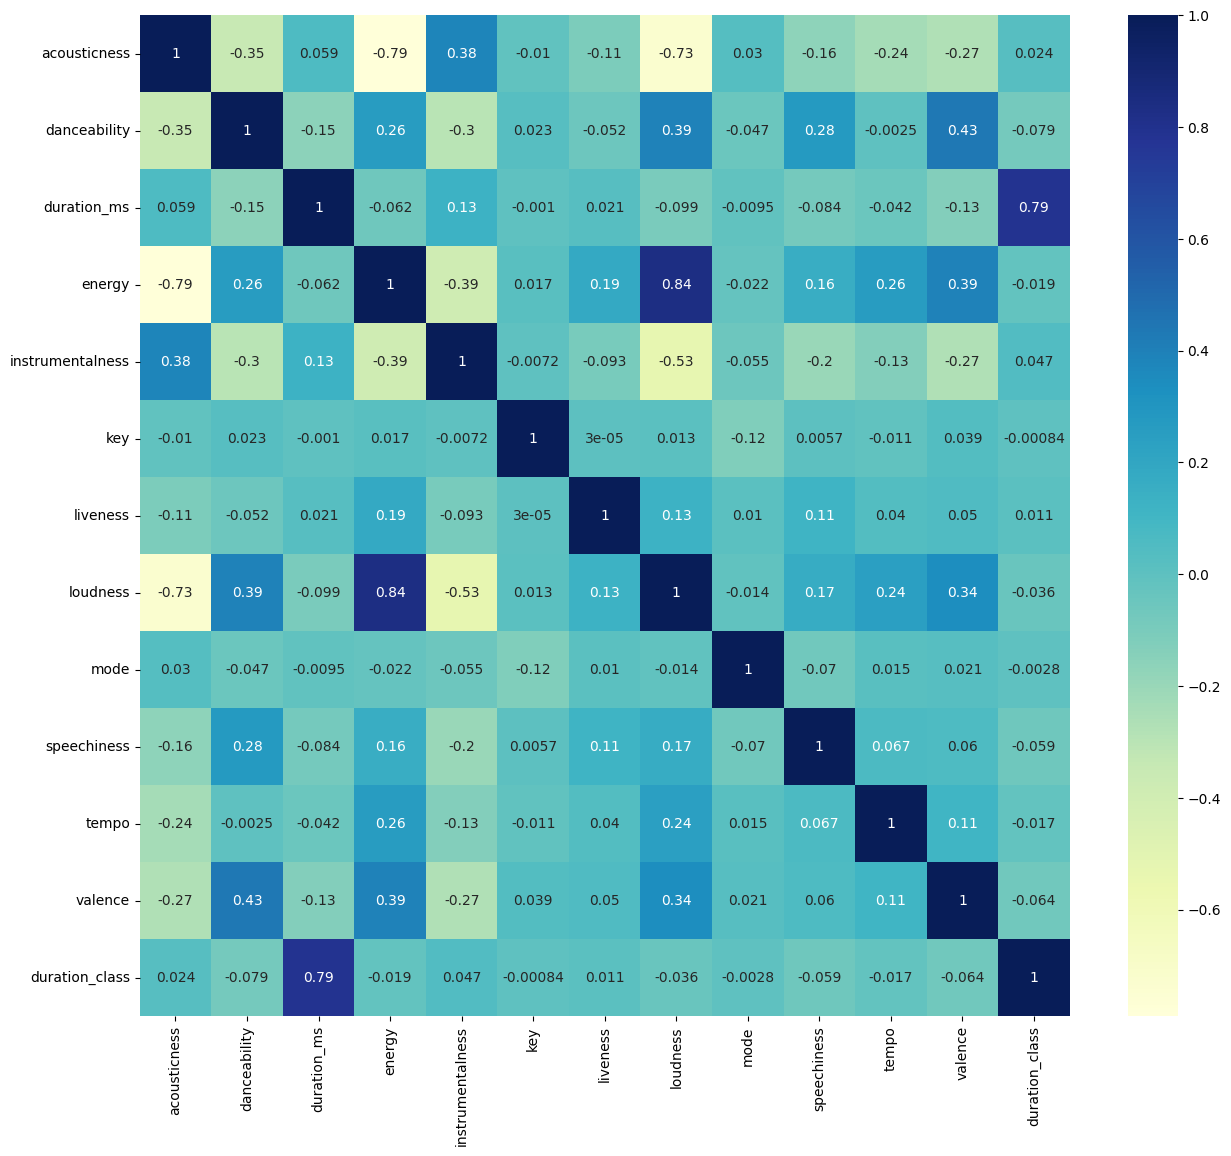

In [1597]:
info_df(features_train)

In [1598]:
vif_data = pd.DataFrame()
vif_data["feature"] = features_train.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(features_train.values, i)
                          for i in range(len(features_train.columns))]
  
print(vif_data)

             feature        VIF
0       acousticness   4.444136
1       danceability  12.086871
2        duration_ms   9.630107
3             energy  17.013087
4   instrumentalness   1.932336
5                key   3.672464
6           liveness   2.591938
7           loudness   8.920534
8               mode   2.549899
9        speechiness   2.132231
10             tempo  16.137641
11           valence   6.451231
12    duration_class   2.582953


In [1634]:
features_traind = features_train.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)
features_validd = features_valid.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)
features_testd = features_test.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)

In [1645]:
def rebalance(data):
    max_val = 10000 
    # create new dataframe 
    _data = pd.DataFrame(columns=data.columns)
    
    # iteratively add sample of songs based on genre 
    for genre in tqdm(data['music_genre'].unique()):
        _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)  
    return _data

In [1646]:
balanced_df = rebalance(train_data)
balanced_df['mode'].replace(mode_dict, inplace=True)
balanced_df['key'] = balanced_df['key'].replace(key_dict).astype(int)
features_trainB, features_validB, target_trainB, target_validB = train_test_split(balanced_df.drop(columns='music_genre'),
                                                                                  balanced_df['music_genre'], test_size=0.2, random_state=RANDOM_STATE)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/3323320446.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _data = _data.append(data[data['music_genre'] == genre].sample(n=max_val, random_state=RANDOM_STATE, replace=True), ignore_index=True, sort=False)
100%|██████████| 10/10 [00:00<00:00, 201.89it/s]


In [1648]:
features_trainB = features_trainB.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)
features_validB = features_validB.drop(['loudness', 'danceability', 'acousticness', 'valence', 'energy', 'duration_ms'],axis=1)

In [1650]:
cat_model = CatBoostClassifier(loss_function='MultiClass',
                                      iterations=10000,
                                      depth=10,
                                      learning_rate=0.01,
                                      random_state=RANDOM_STATE,
                                      early_stopping_rounds = 200
                                      ).fit(features_trainB, 
                                        target_trainB,
                                        eval_set=(features_validB, target_validB))

0:	learn: 2.2921886	test: 2.2927168	best: 2.2927168 (0)	total: 54ms	remaining: 9m
1:	learn: 2.2816613	test: 2.2826100	best: 2.2826100 (1)	total: 107ms	remaining: 8m 54s
2:	learn: 2.2715615	test: 2.2729067	best: 2.2729067 (2)	total: 159ms	remaining: 8m 49s
3:	learn: 2.2624966	test: 2.2642632	best: 2.2642632 (3)	total: 210ms	remaining: 8m 45s
4:	learn: 2.2532760	test: 2.2554797	best: 2.2554797 (4)	total: 263ms	remaining: 8m 46s
5:	learn: 2.2440654	test: 2.2466338	best: 2.2466338 (5)	total: 323ms	remaining: 8m 58s
6:	learn: 2.2349787	test: 2.2378989	best: 2.2378989 (6)	total: 391ms	remaining: 9m 18s
7:	learn: 2.2265341	test: 2.2298460	best: 2.2298460 (7)	total: 443ms	remaining: 9m 13s
8:	learn: 2.2183191	test: 2.2220257	best: 2.2220257 (8)	total: 496ms	remaining: 9m 10s
9:	learn: 2.2103892	test: 2.2144586	best: 2.2144586 (9)	total: 574ms	remaining: 9m 33s
10:	learn: 2.2017256	test: 2.2061674	best: 2.2061674 (10)	total: 625ms	remaining: 9m 27s
11:	learn: 2.1943503	test: 2.1992124	best: 2.1

In [1472]:
import numpy as np
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sb.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

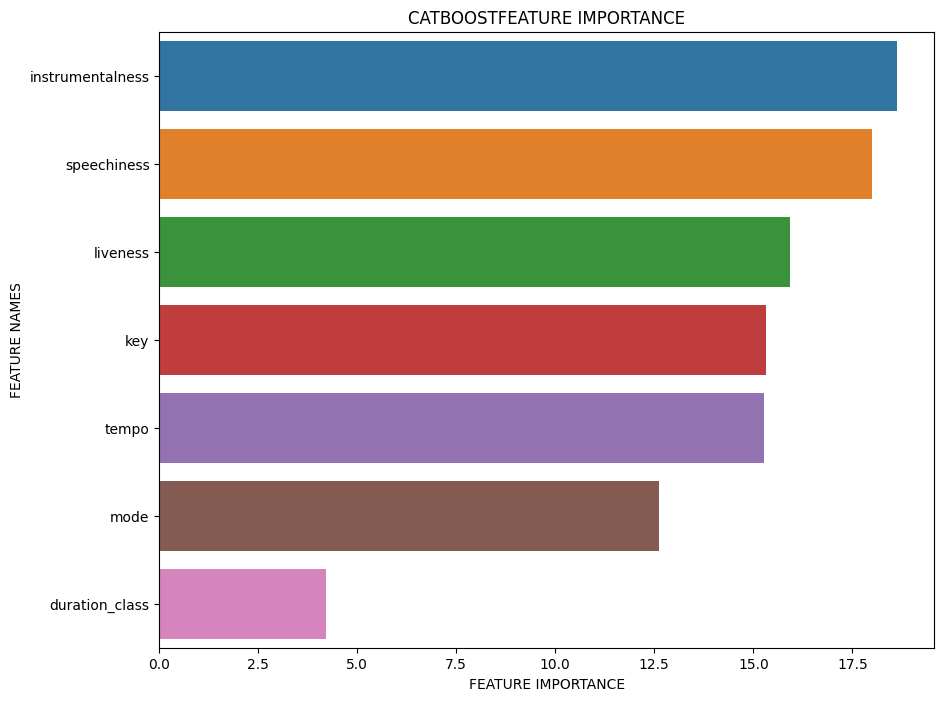

In [1652]:
plot_feature_importance(cat_model.get_feature_importance(),features_trainB.columns,'CATBOOST')

/var/folders/n5/30cd9v_56sz_qrnt8mp_9df40000gn/T/ipykernel_1051/4225226678.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(features_trainB.corr(method='spearman'), annot = True, linewidths=.2, cmap=sb.diverging_palette(220, 10, as_cmap=True))


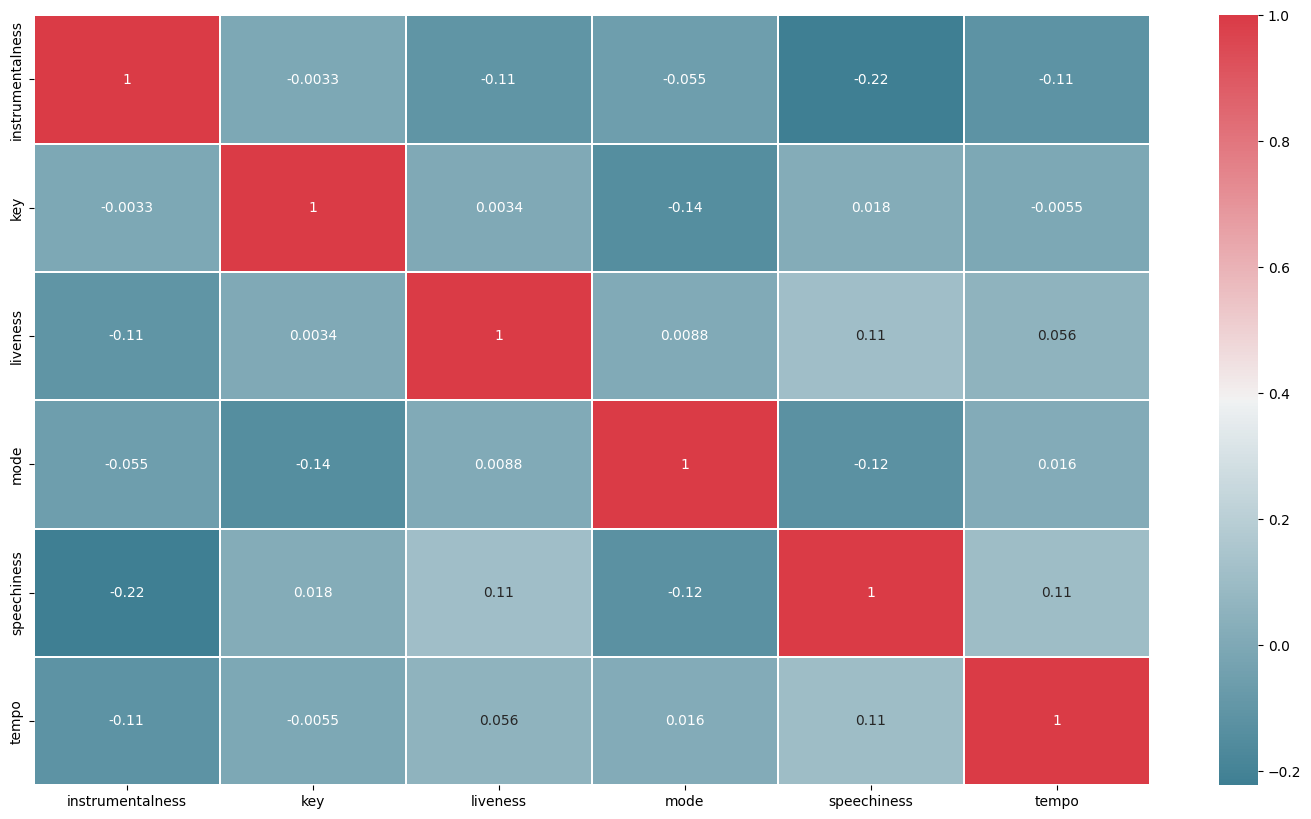

In [1653]:
plt.figure(figsize = (18, 10))
sb.heatmap(features_trainB.corr(method='spearman'), annot = True, linewidths=.2, cmap=sb.diverging_palette(220, 10, as_cmap=True))
plt.show()

In [1654]:
cat_features = list(range(0, features_trainB.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6]


In [1640]:
fast_model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    features_traind, target_train,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1641]:
tunned_model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=3000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    features_traind, target_train,
    verbose=False,
    eval_set=(features_validd, target_valid),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [1642]:
best_model = CatBoostClassifier(
    random_seed=RANDOM_STATE,
    iterations=int(tunned_model.tree_count_ * 1.6),
)
best_model.fit(
    features_traind, target_train,
    verbose=500
)

Learning rate set to 0.041398
0:	learn: 2.2655310	total: 14.9ms	remaining: 40s
500:	learn: 1.5593055	total: 5.88s	remaining: 25.6s
1000:	learn: 1.4756701	total: 11.7s	remaining: 19.7s
1500:	learn: 1.4138812	total: 17.5s	remaining: 13.8s
2000:	learn: 1.3596181	total: 23.3s	remaining: 7.94s
2500:	learn: 1.3104568	total: 29s	remaining: 2.12s
2683:	learn: 1.2933449	total: 31.1s	remaining: 0us


In [1655]:
fbeta_score(target_validB,cat_model.predict(features_validB),average='macro',beta=0.5)

0.7130784737313152

In [1656]:
print(classification_report(target_validB, cat_model.predict(features_validB)))

              precision    recall  f1-score   support

 Alternative       0.69      0.61      0.65      1974
       Anime       0.80      0.66      0.72      1998
       Blues       0.70      0.70      0.70      1998
   Classical       0.79      0.84      0.82      2009
     Country       0.64      0.79      0.71      2009
  Electronic       0.76      0.79      0.77      1998
     Hip-Hop       0.67      0.73      0.70      1991
        Jazz       0.75      0.72      0.73      2071
         Rap       0.66      0.67      0.67      1937
        Rock       0.67      0.62      0.65      2015

    accuracy                           0.71     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.72      0.71      0.71     20000



In [1657]:
pred_cat = cat_model.predict_proba(features_test)
pred_cat[0]

array([4.24700342e-01, 1.18422965e-03, 3.52264237e-04, 6.11835841e-04,
       6.19171592e-04, 1.74945421e-02, 2.78384508e-01, 7.28996439e-03,
       2.69115896e-01, 2.47246365e-04])

In [1658]:
pred_cat[0].argmax()

0

In [1659]:
cat_model.classes_[pred_cat[0].argmax()]

'Alternative'

In [1660]:
pred_cat = cat_model.predict(features_test)


In [1661]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': pred_cat.ravel()
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Alternative
1,72394,Rock
2,88081,Rap
3,78331,Country
4,72636,Jazz
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Hip-Hop
5097,79778,Electronic


In [554]:
submission = pd.DataFrame({
    'instance_id': submit_test['instance_id'],
    'music_genre': pred_cat.ravel()
})
submission.to_csv('submission.csv', index=False)
submission

,instance_id,music_genre
0,48564,Alternative
1,72394,Rock
2,88081,Rap
3,78331,Country
4,72636,Blues
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


# Pipeline

In [505]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

cat_features = list(range(0, features_train_up.shape[1]))
cat_transformer = Pipeline(steps=[('imputer', IterativeImputer(random_state=RANDOM_STATE)),
                                  ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('num', cat_transformer, cat_features)
])

In [537]:
# ('preprocessor', preprocessor),
model = CatBoostClassifier(loss_function='MultiClass',
                                      iterations=300,
                                      depth=10,
                                      learning_rate=0.2,
                                      random_state=RANDOM_STATE,
                                      ).fit(features_train, 
                                        target_train,
                                        eval_set=(features_test.drop(['instance_id','track_name', 'obtained_date'], axis=1), target_test))

CatBoostError: /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/loss_description.cpp:18: auto loss is not supported

In [683]:
target_pred = model.predict(features_test.drop(['track_name', 'obtained_date'], axis=1))

pred = pd.DataFrame({'Actual': submit_test['music_genre'], 'Predicted':target_pred.ravel()})
pred

,Actual,Predicted
0,Hip-Hop,Alternative
1,Alternative,Alternative
2,Rap,Rap
3,Anime,Country
4,Anime,Jazz
...,...,...
5094,Alternative,Country
5095,Blues,Hip-Hop
5096,Electronic,Hip-Hop
5097,Country,Electronic


https://www.kaggle.com/code/shubhamlipare/random-forest-with-hyperparameter-tuning

https://www.kaggle.com/code/zjohnson87/music-features-analysis-genre-classification